In [1]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

2025-05-20 14:50:36.794374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747752636.993691      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747752637.053363      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# === 1. DATA AUGMENTATION & SPLIT ===
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

In [3]:
# === 2. LOAD DATA ===
train_dir = '/kaggle/input/dtsbangnhau/Dataset Hminh fix/Train'
test_dir = '/kaggle/input/dtsbangnhau/Dataset Hminh fix/Test'

train = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 5944 images belonging to 121 classes.
Found 1468 images belonging to 121 classes.
Found 431 images belonging to 121 classes.


In [4]:
# === 3. MODEL BUILDING ===
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
predictions = Dense(121, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

I0000 00:00:1747752656.578290      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
# === 4. CALLBACKS ===
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('traffic_sign_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [6]:
# === 5. TRAINING PHASE 1 ===
history_1 = model.fit(
    train,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=len(val),
    epochs=15,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15


I0000 00:00:1747752663.224894      79 service.cc:148] XLA service 0x7a2bb4012070 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747752663.225989      79 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1747752663.766144      79 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/186 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.0000e+00 - loss: 5.8090 

I0000 00:00:1747752672.873851      79 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step - accuracy: 0.0268 - loss: 5.2274
Epoch 1: val_accuracy improved from -inf to 0.05381, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 132s 641ms/step - accuracy: 0.0269 - loss: 5.2252 - val_accuracy: 0.0538 - val_loss: 4.5255 - learning_rate: 1.0000e-04
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 341ms/step - accuracy: 0.1301 - loss: 3.8050
Epoch 2: val_accuracy improved from 0.05381 to 0.30450, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 80s 428ms/step - accuracy: 0.1302 - loss: 3.8040 - val_accuracy: 0.3045 - val_loss: 3.6269 - learning_rate: 1.0000e-04
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.2729 - loss: 3.0649
Epoch 3: val_accuracy improved from 0.30450 to 0.57289, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 78s 421ms/step - accuracy: 0.2731 - loss: 3.0641 - val_accuracy: 0.5729 - val_loss: 2.5378 - learning_rate: 1.0000e-04
Epoch 4/15
186/186 ━━━━

In [7]:
# === 6. TRAINING PHASE 2 (Fine-tune) ===
for layer in base_model.layers[-4:]:
    layer.trainable = True

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

history_2 = model.fit(
    train,
    steps_per_epoch=len(train),
    validation_data=val,
    validation_steps=len(val),
    epochs=15,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

model.save('VGG16_SignTrafficVN.h5')

Epoch 1/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - accuracy: 0.8783 - loss: 0.4835
Epoch 1: val_accuracy improved from 0.84196 to 0.85695, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 90s 442ms/step - accuracy: 0.8785 - loss: 0.4832 - val_accuracy: 0.8569 - val_loss: 0.5383 - learning_rate: 1.0000e-05
Epoch 2/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9239 - loss: 0.3503
Epoch 2: val_accuracy improved from 0.85695 to 0.87943, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 79s 423ms/step - accuracy: 0.9239 - loss: 0.3502 - val_accuracy: 0.8794 - val_loss: 0.4735 - learning_rate: 1.0000e-05
Epoch 3/15
186/186 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9452 - loss: 0.2804
Epoch 3: val_accuracy improved from 0.87943 to 0.88352, saving model to traffic_sign_model.h5
186/186 ━━━━━━━━━━━━━━━━━━━━ 79s 425ms/step - accuracy: 0.9452 - loss: 0.2803 - val_accuracy: 0.8835 - val_loss: 0.4478 - learning_rate: 1.0000e-05
Epoch 4/15

In [8]:
# === 7. FINAL TEST EVALUATION ===
test_loss, test_acc = model.evaluate(test, steps=len(test))
print(f"Final test accuracy: {test_acc:.4f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 465ms/step - accuracy: 0.8679 - loss: 0.4882
Final test accuracy: 0.8910


In [9]:
# === 8. CLASSIFICATION REPORT & CONFUSION MATRIX ===
y_true = test.classes
y_pred_probs = model.predict(test, steps=len(test))
y_pred = np.argmax(y_pred_probs, axis=1)
class_labels = list(test.class_indices.keys())

report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
conf_matrix = confusion_matrix(y_true, y_pred)

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


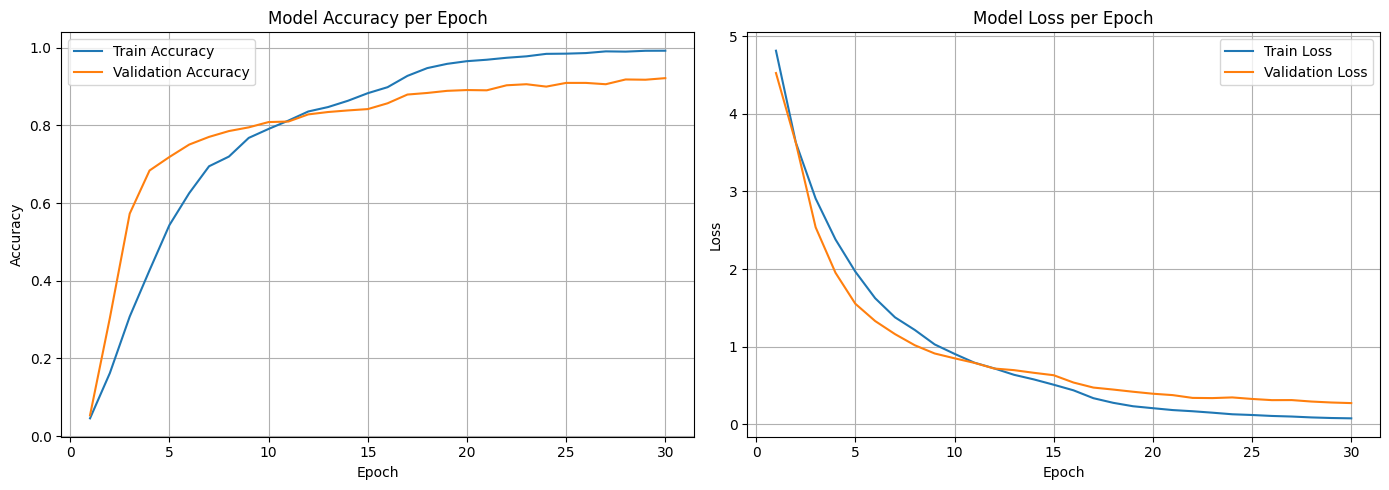

In [10]:
# === 9. PLOT ACCURACY & LOSS ===
train_acc = history_1.history['accuracy'] + history_2.history['accuracy']
val_acc = history_1.history['val_accuracy'] + history_2.history['val_accuracy']
train_loss = history_1.history['loss'] + history_2.history['loss']
val_loss = history_1.history['val_loss'] + history_2.history['val_loss']
epochs = range(1, len(train_acc) + 1)

plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Model Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Model Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

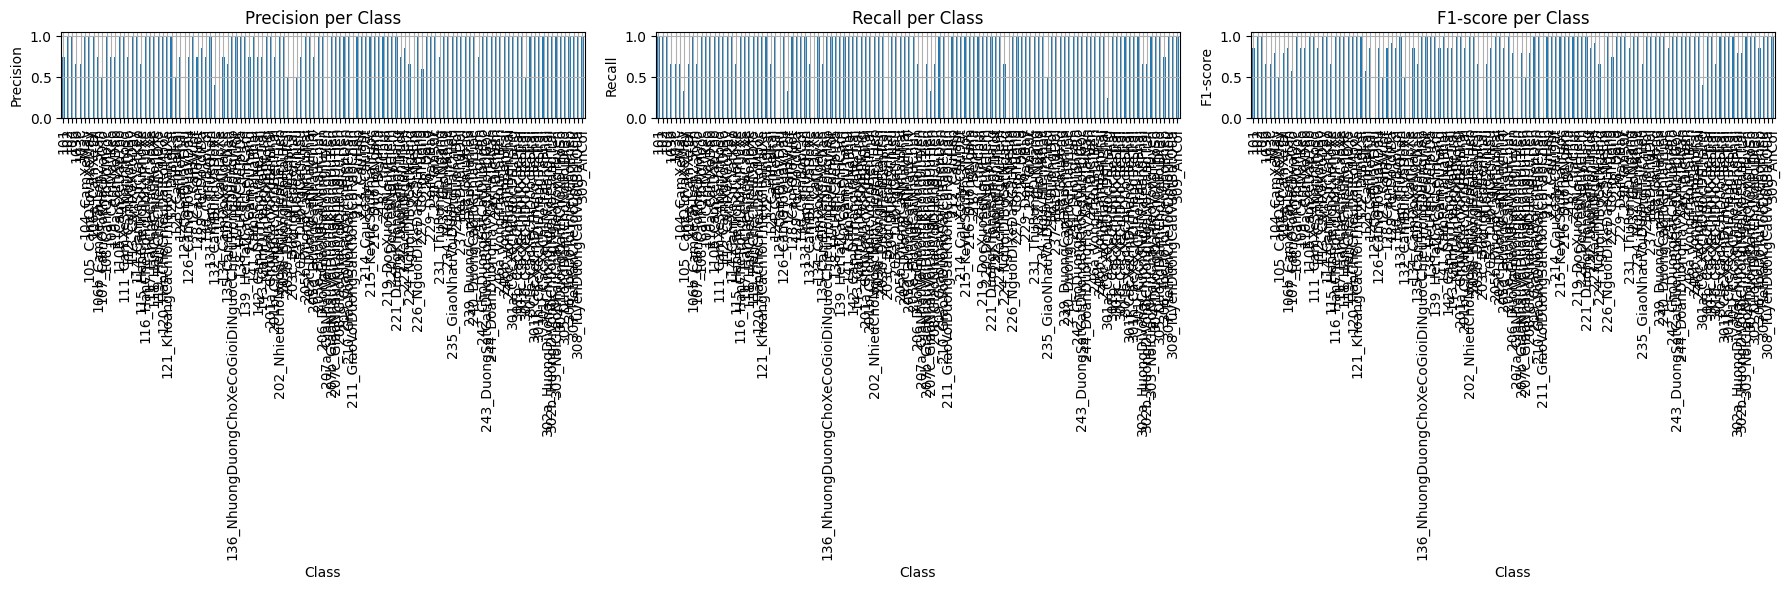

In [11]:
# === 10. PLOT PRECISION, RECALL, F1-SCORE ===
metrics_df = pd.DataFrame(report).transpose()
metrics_df = metrics_df.loc[class_labels, ['precision', 'recall', 'f1-score']]

plt.figure(figsize=(18, 6))
for idx, metric in enumerate(['precision', 'recall', 'f1-score']):
    plt.subplot(1, 3, idx + 1)
    metrics_df[metric].plot(kind='bar')
    plt.title(f'{metric.capitalize()} per Class')
    plt.xlabel('Class')
    plt.ylabel(metric.capitalize())
    plt.xticks(rotation=90)
    plt.grid(True)
plt.tight_layout()
plt.show()

/tmp/ipykernel_19/1538010439.py:7: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


<Figure size 1200x1200 with 0 Axes>

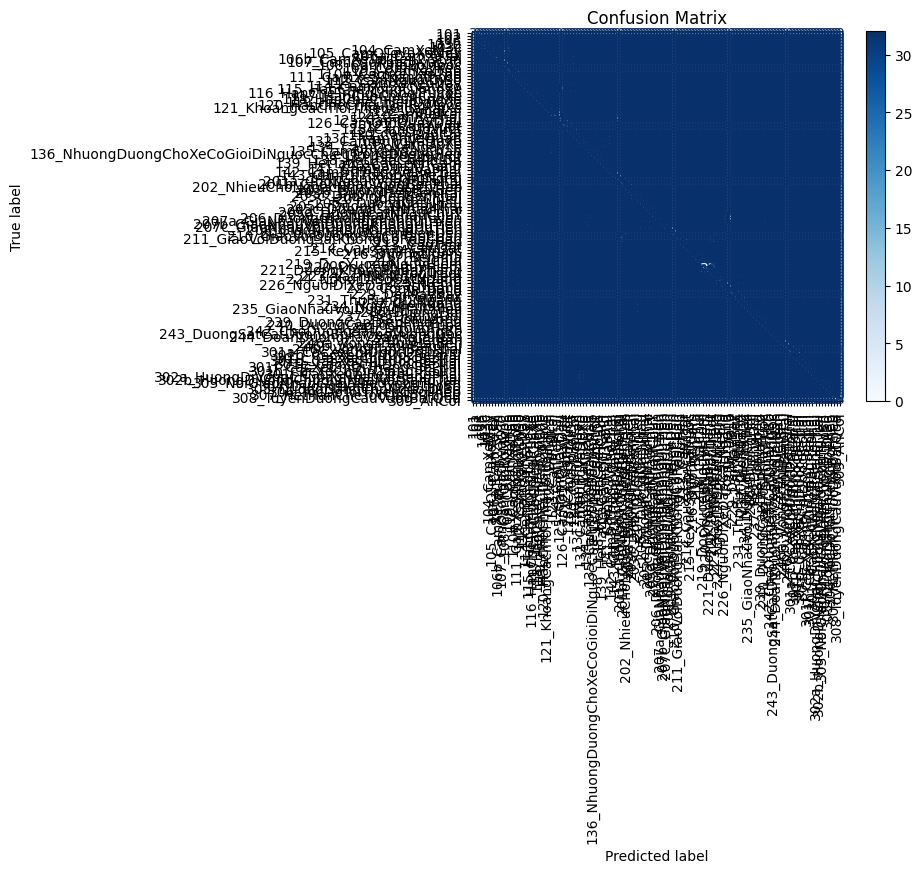

In [12]:
# === 11. CONFUSION MATRIX PLOT ===
plt.figure(figsize=(12, 12))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_labels)
disp.plot(xticks_rotation=90, cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.metrics import classification_report
import pandas as pd

report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
df_report = pd.DataFrame(report).transpose()

df_metrics = df_report.loc[class_labels, ['precision', 'recall', 'f1-score']]

df_metrics = df_metrics.round(2)

print(df_metrics.to_string())


                                                     precision  recall  f1-score
101                                                       0.75    1.00      0.86
102                                                       1.00    1.00      1.00
103                                                       1.00    1.00      1.00
103b                                                      0.67    0.67      0.67
103c                                                      0.67    0.67      0.67
104_CamXeMay                                              1.00    0.67      0.80
105_CamOTovaXeMay                                         1.00    0.33      0.50
106a_CamXeTai                                             1.00    0.67      0.80
106b_CamXeTaiTren2.5tan                                   0.75    1.00      0.86
107_CamOToKhachvaOTo                                      0.50    0.67      0.57
108_CamOToRoMooc                                          1.00    1.00      1.00
109_CamMayKeo               

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
